In [56]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from src.utils import *
import json
from matplotlib.ticker import MaxNLocator
import numpy as np
from sklearn.linear_model import LinearRegression

In [57]:
# Metric files: Dictionnary
#   - Key: metrics category
#   - Value: array of Tuples:
#       - Elt 0: index of data point in global graphs
#       - Elt 1: path to metric file
#       - Elt 2: legend in detailed graphs, None if not displayed

metric_files = {
    'KW-train': [
        (0, 'data_output/metrics_raw.csv', 'train-raw'),
        (1, 'data_output/metrics_epoch_1_KW.csv', None),
        (3, 'data_output/metrics_epoch_3_KW.csv', None),
        (4, 'data_output/metrics_epoch_4_KW.csv', None),
        (5, 'data_output/metrics_epoch_5_KW.csv', None),
        (6, 'data_output/metrics_epoch_6_KW.csv', None),
        (8, 'data_output/metrics_epoch_8_KW.csv', None),
        (9, 'data_output/metrics_epoch_9_KW.csv', None),
        (10, 'data_output/metrics_epoch_10_KW.csv', 'KW-train-10'),
    ],
    'BART-train': [
        (0, 'data_output/metrics_raw.csv', None),
        (1, 'data_output/metrics_epoch_1_BART.csv', None),
        (3, 'data_output/metrics_epoch_3_BART.csv', None),
        (4, 'data_output/metrics_epoch_4_BART.csv', None),
        (5, 'data_output/metrics_epoch_5_BART.csv', None),
        (6, 'data_output/metrics_epoch_6_BART.csv', None),
        (8, 'data_output/metrics_epoch_8_BART.csv', None),
        (9, 'data_output/metrics_epoch_9_BART.csv', None),
        (10, 'data_output/metrics_epoch_10_BART.csv', 'BART-train-10'),
    ],
    'KW-eval': [
        
    ],
    'BART-eval': [
        
    ]
}

In [59]:
# Loading data

all_data = {}
means = {}
for k, v in metric_files.items():
    all_data[k] = [pd.read_csv(file) for (index, file, display) in v]
    means[k] = [{'epoch': index} for (index, file, display) in v]


In [79]:
def generation_analysis(generation_file):
    gen_data = json.load(open(generation_file, 'r'))

    # Example of paragraphs
    sample = 300
    print('\nORIGINAL:\n', gen_data[sample]['original']['P2'])
    print('\nGENERATED:\n', gen_data[sample]['generated'])

    # Counting occurences of [P2] token
    print("\n\tGenerated paragraphs with [P2] token inside:",
          len([1 for entry in gen_data if '[P2]' in entry['generated']]),
         '/', len(gen_data))

    # Checking that endoftext tokens are respected
    eot = '<|endoftext|>'
    for entry in gen_data:
        gen = entry['generated']
        index_of_eot = gen.find(eot)
        if index_of_eot > -1:
            while index_of_eot < len(gen):
                assert gen[index_of_eot:].startswith(eot)
                index_of_eot += len(eot)

    print("\n\tValidated that there was no text after <|endoftext|>")

    # Histogram of generated and original paragraphs' lengths
    plt.figure(figsize=(10, 10))
    sns.distplot([len(entry['generated'].replace('<|endoftext|>', '')) for entry in gen_data], bins=[i*100 for i in range(20)], axlabel='Length (chars)', label='Generated')
    sns.distplot([len(entry['original']['P2']) for entry in gen_data], axlabel='Length (chars)', bins=[i*100 for i in range(20)], label='Original')
    plt.legend()
    plt.show()

    # Correlation of generated and original paragraphs' lengths
    plt.figure(figsize=(10, 10))
    data_points = np.array([[len(entry['original']['P2']) for entry in gen_data], [len(entry['generated'].replace('<|endoftext|>', '')) for entry in gen_data]], dtype=int).T
    sns.scatterplot(data_points[:, 0], data_points[:, 1])

    reg = LinearRegression().fit(data_points[:, 0][:, np.newaxis], data_points[:, 1])
    predicted = reg.predict(np.array([i for i in range(2000)])[:, np.newaxis])

    print("\tCorrelation score:", reg.score(data_points[:, 0][:, np.newaxis], data_points[:, 1]))

    sns.lineplot(x=[i for i in range(2000)], y=predicted, color='black')

    plt.xlabel('Original length (chars)')
    plt.ylabel('Generated length (chars)')
    plt.show()

def display_metrics_distributions():
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 7.5*3))

    for category, dataframes in all_data.items():
        for i, d in enumerate(dataframes):
            lbl = metric_files[category][i][2]
            display = lbl is not None

            perplex = [elt for elt in d['perplexity'] if elt < 5]

            if display:
                sns.distplot(d['similarity'], ax=axs[0, 0], axlabel='BERT-similarity', label=lbl)
                sns.distplot(perplex, ax=axs[0, 1], axlabel='GPT2-perplexity', label=lbl)
                sns.distplot([elt for elt in d['rouge_1'] if not pd.isnull(elt)], ax=axs[1, 0], axlabel='rouge_1', label=lbl)
                sns.distplot([elt for elt in d['rouge_2'] if elt < 0.1], ax=axs[1, 1], axlabel='rouge_2', label=lbl)
                sns.distplot([elt for elt in d['rouge_l'] if not pd.isnull(elt)], ax=axs[2, 0], axlabel='rouge_l', label=lbl)
                sns.distplot(d['bleu_score']*1e230, ax=axs[2, 1], axlabel='bleu_score', label=lbl)

            means[category][i]['similarity'] = d['similarity'].mean()
            means[category][i]['perplexity'] = sum(perplex) / len(perplex)
            means[category][i]['rouge-1'] = d['rouge_1'].mean()
            means[category][i]['rouge-2'] = d['rouge_2'].mean()
            means[category][i]['rouge-l'] = d['rouge_l'].mean()
            means[category][i]['bleu-score'] = d['bleu_score'].mean()

    axs[0, 0].legend()
    axs[0, 1].legend()
    axs[1, 0].legend()
    axs[1, 1].legend()
    axs[2, 0].legend()
    axs[2, 1].legend()
    plt.show()

def display_detailed_entities_distributions():
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))

    for category, dataframes in all_data.items():
        for i, d in enumerate(dataframes):
            lbl = metric_files[category][i][2]
            display = lbl is not None

            if display:
                sns.distplot([elt for elt in d['proportion_of_persons'] if elt != -1], bins=10, ax=axs[0, 0], axlabel='persons-proportion', label=lbl)
                sns.distplot([elt for elt in d['proportion_of_locations'] if elt != -1], bins=10, ax=axs[0, 1], axlabel='locations-proportion', label=lbl)
                sns.distplot([elt for elt in d['proportion_of_organisations'] if elt != -1], bins=10, ax=axs[1, 0], axlabel='organisations-proportion', label=lbl)
                sns.distplot([elt for elt in d['proportion_of_misc'] if elt != -1], ax=axs[1, 1], bins=10, axlabel='misc-proportion', label=lbl)

    axs[0, 0].legend()
    axs[0, 1].legend()
    axs[1, 0].legend()
    axs[1, 1].legend()
    plt.show()
    
def display_entities_distributions():
    fig = plt.subplots(figsize=(10, 10))

    for category, dataframes in all_data.items():
        for i, d in enumerate(dataframes):
            lbl = metric_files[category][i][2]
            display = lbl is not None

            new_data = []
            for per, loc, org, mis in zip(d['proportion_of_persons'], d['proportion_of_locations'], d['proportion_of_organisations'], d['proportion_of_misc']):
                elts = [elt for elt in [per, loc, org, mis] if elt != -1]
                if len(elts) == 0:
                    continue
                new_data.append(sum(elts) / len(elts))

            if display:
                sns.distplot(new_data, axlabel='entities-proportion', bins=20, label=lbl)
            means[category][i]['entities-proportion'] = sum(new_data) / len(new_data)
    plt.legend()
    plt.show()

def display_keywords_distributions():
    fig = plt.subplots(figsize=(10, 10))
    bins = 20

    for category, dataframes in all_data.items():
        for i, d in enumerate(dataframes):
            lbl = metric_files[category][i][2]
            display = lbl is not None

            elts = [elt for elt in d['keyword_proportion'] if not pd.isnull(elt)]
            if display:
                sns.distplot(elts, bins=[i/bins for i in range(bins)], axlabel='keywords-proportion', label=lbl)
            means[category][i]['keywords-proportion'] = sum(elts) / len(elts)
            
    plt.legend()
    plt.show()

def display_training_graphs():
    fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(15, 15))

    metrics = ['similarity', 'perplexity', 'rouge-1', 'rouge-2', 'rouge-l', 'bleu-score', 'entities-proportion', 'keywords-proportion']

    for i, metric in enumerate(metrics):
        x = i % 2
        y = i // 2

        for category, cat_means in means.items():
            axs[y, x].plot([m['epoch'] for m in cat_means], [m[metric] for m in cat_means], label=category)

        axs[y, x].set_title('Mean "' + metric + '" evolution')
        axs[y, x].xaxis.set_major_locator(MaxNLocator(integer=True))
        if y == 3:
            axs[y, x].set_xlabel('epochs')
        axs[y, x].set_ylabel('score')
        axs[y, x].legend(loc='lower right')

    plt.show()


ORIGINAL:
 “Why do you cry, my darling?” he said. “O—I don’t know!” she murmured. As she saw and felt more clearly the position she was in she became agitated and tried to withdraw. “Well, I have betrayed my feeling, Tess, at last,” said he, with a curious sigh of desperation, signifying unconsciously that his heart had outrun his judgement. “That I—love you dearly and truly I need not say. But I—it shall go no further now—it distresses you—I am as surprised as you are. You will not think I have presumed upon your defencelessness—been too quick and unreflecting, will you?”

GENERATED:
 Had he not had not come to her aid her with love at all? It seemed strange to be with what had he not? She felt more that she should not have been afraid of this. But she was more than she dared, yet her heart rose to her resolve, more than she was prepared to say it, to let him know that she was a woman who did not love him, who had not even yet felt herself equal to this situation, and who, in the com

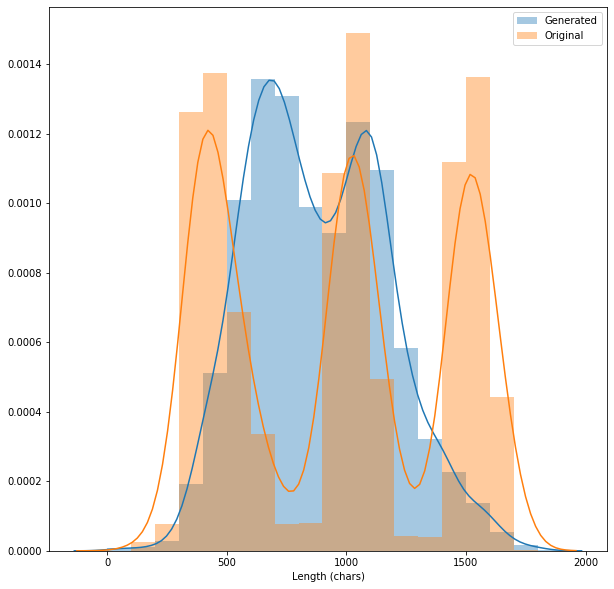

	Correlation score: 0.35534248152395154


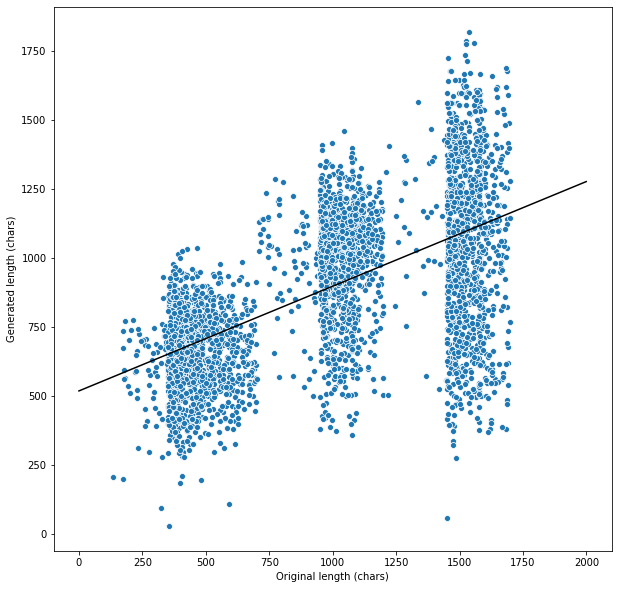

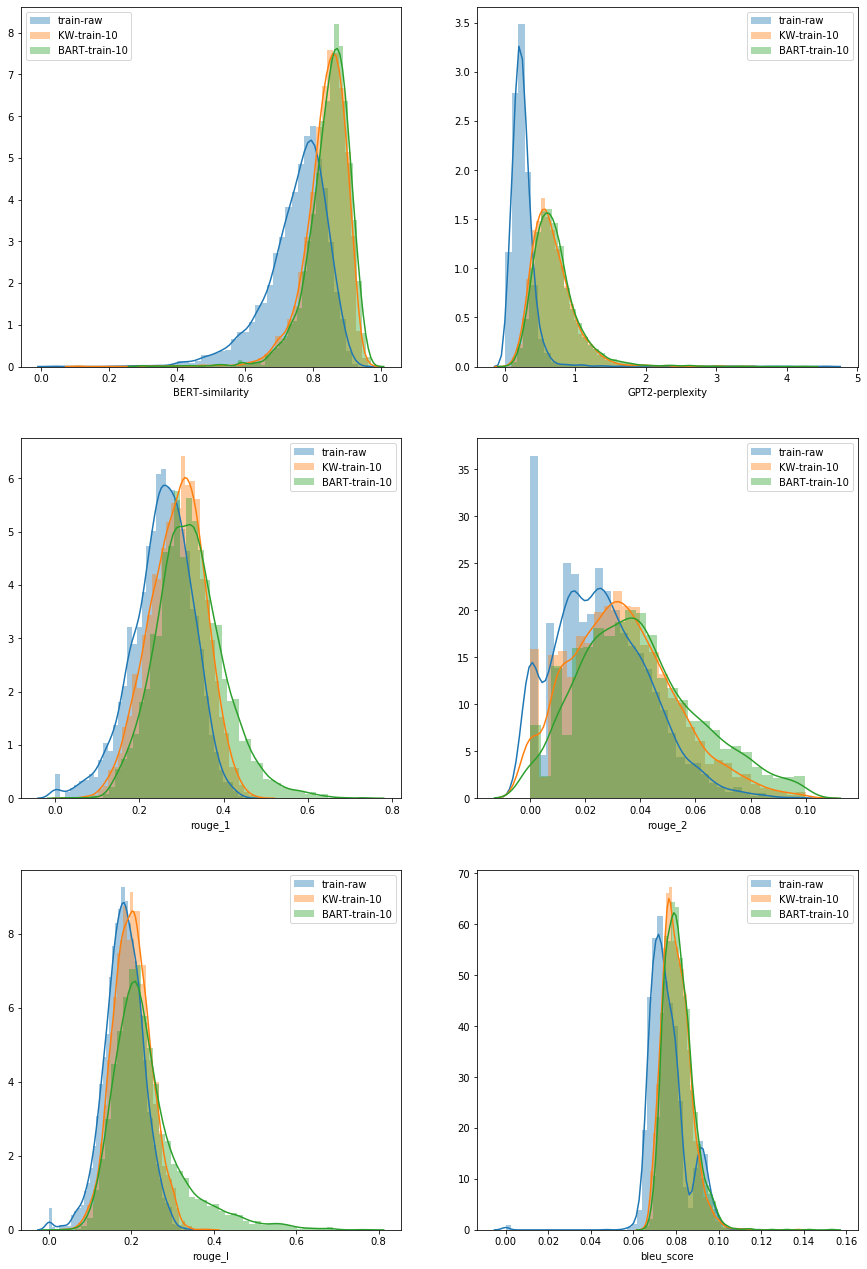

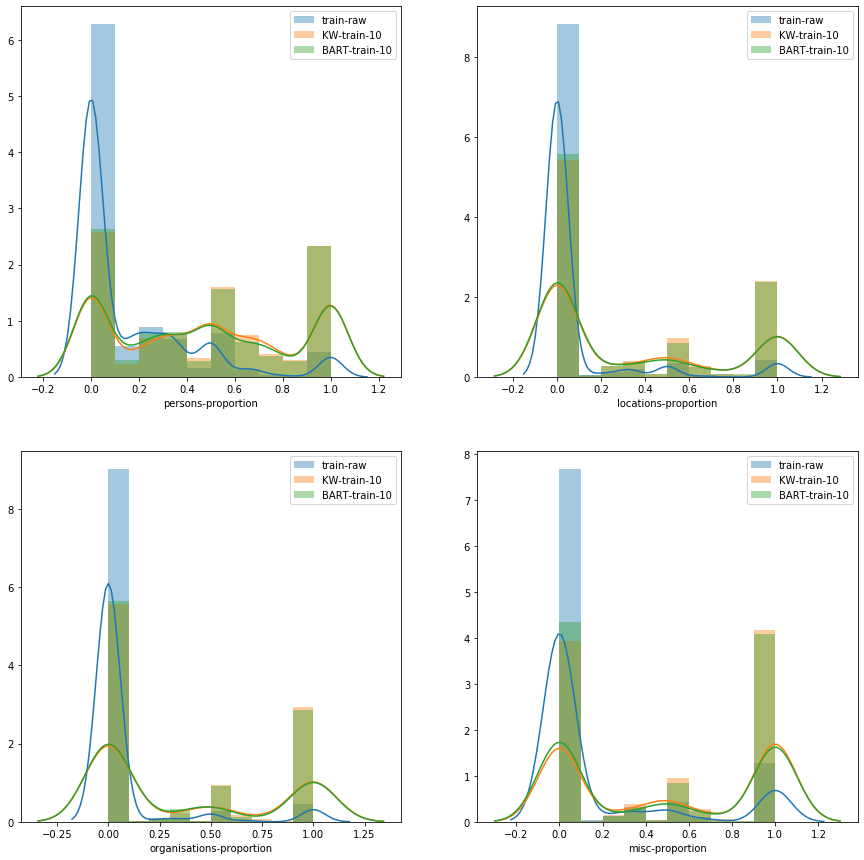

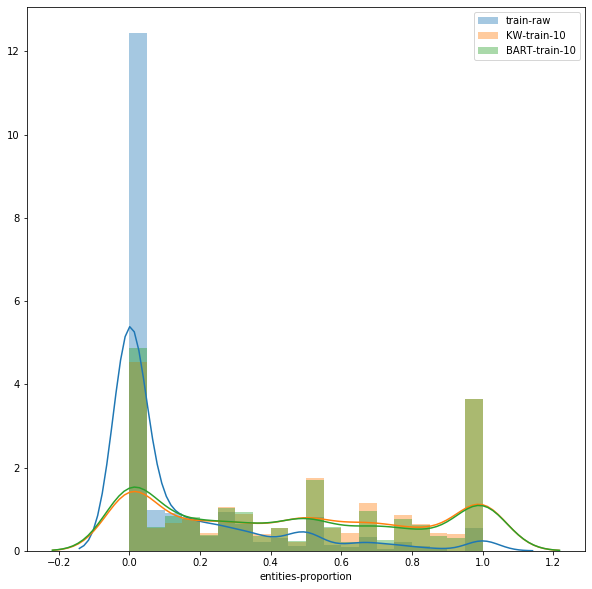

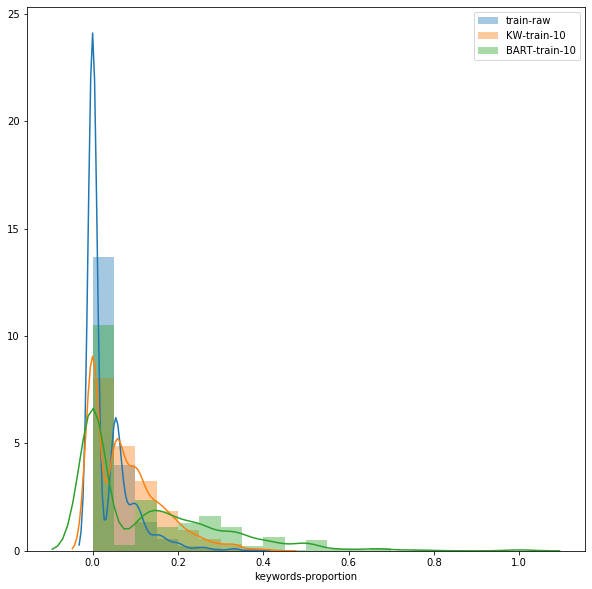

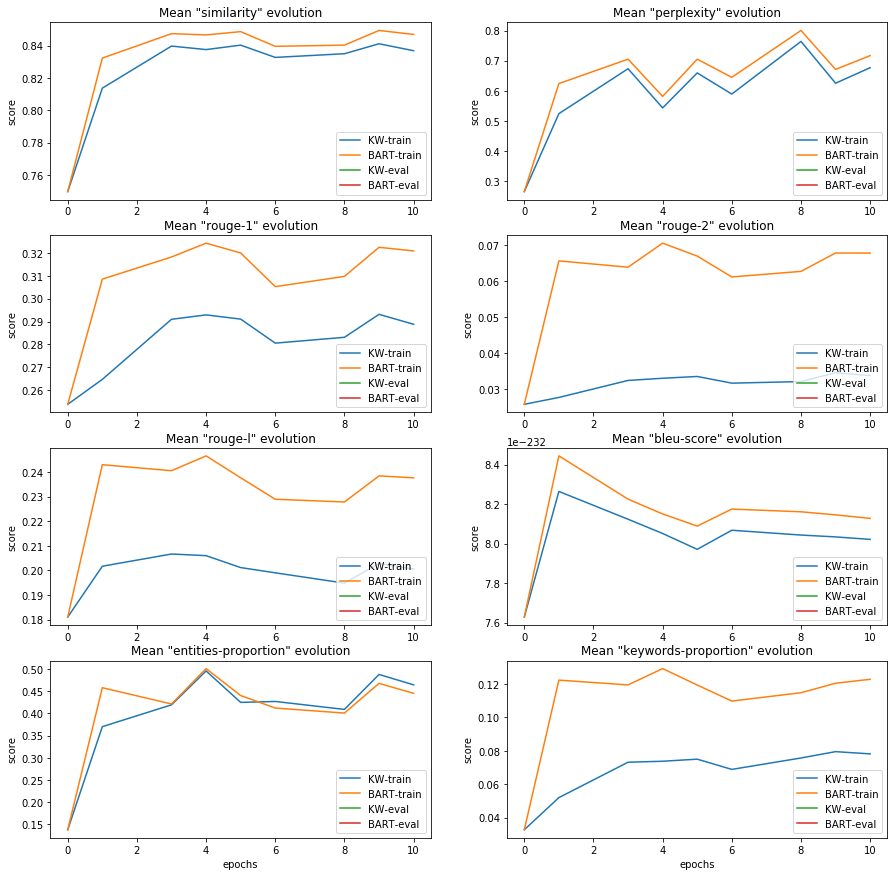

In [80]:
# File to analyse
gen_file = 'data_output/generation_epoch_10_BART.json'
generation_analysis(gen_file)

display_metrics_distributions()
display_detailed_entities_distributions()
display_entities_distributions()
display_keywords_distributions()
display_training_graphs()